In [1]:
import numpy as np                # library for mathematical operations with arrays
import pandas as pd               # library for data frames; includes useful functions for date arithmetic
import xarray as xr               # library for arrays, especially tailored to weather data
import matplotlib.pyplot as plt   # library for basic plotting
import datetime                   # library for date manipulation

from os import path
from confer_wp3.plotting import plot_fields                        # function for visualizing spatial data in a map
from confer_wp3.plotting import get_nearest_grid_index             # helper function to find the grid indices for a selected location
from confer_wp3.downscaling import calculate_target_percentiles    # function for calculating the percentiles of the target data climatology
from confer_wp3.downscaling import calculate_forecast_percentiles  # function for calculating the percentiles of the forecast climatology
from confer_wp3.downscaling import downscale_forecasts             # function for performing the downscaling
from confer_wp3.utils import load_and_interpolate_forecast         # function to load and interpolate the (raw) ensemble forecasts

The following variables specify the paths where the forecast and observation data are stored:

In [2]:
fcst_dir = '/home/confer/michael/Data/Forecasts_daily_grib/'
chirps_dir = '/home/confer/michael/Data/CHIRPS_pentad/'
imerg_dir = '/home/confer/michael/Data/IMERG_pentad/'
rfe2_dir = '/home/confer/michael/Data/RFE2_pentad/'
percentile_dir = '/home/confer/michael/Data/Percentiles/'
output_dir = '/home/confer/michael/Data/Forecasts_downscaled/'

Now, we set a number of parameters defining our forecast domain, training period, forecast year, etc.:

In [3]:
year_train_start = 2001   # first year for which we have forecast and observation data for estimating percentiles
year_train_end = 2023     # last year for which we have forecast and observation data for estimating percentiles
year_fcst = 2024          # year for which the bias-corrected forecasts should be generated

month_init = 'aug'        # forecast initialization month

lon_bnds = [20, 53]       # longitude range of the domain of interest
lat_bnds = [-15, 23]      # latitude range of the domain of interest

system = 'ecmwf'          # forecast system to be bias-corrected
target = 'rfe2'           # data set against which the forecasts should be bias-corrected

target_dir = {'chirps':chirps_dir, 'imerg':imerg_dir, 'rfe2':rfe2_dir}[target]

If not already available, load ground truth data for training period, aggregate to pentads, and calculate percentiles of the associated climatology:

In [4]:
filename_pct_target = f'{percentile_dir}percentiles_{target}_{year_train_start}_{year_train_end}.nc'

if not path.exists(filename_pct_target):
    calculate_target_percentiles(target, year_train_start, year_train_end, lon_bnds, lat_bnds, target_dir, filename_pct_target)

data_load = xr.open_dataset(filename_pct_target, engine='netcdf4')
lon_target = data_load.lon.values
lat_target = data_load.lat.values
pctl_target = data_load.percentile.values
data_load.close()

nlon = len(lon_target)
nlat = len(lat_target)

If not already available, load forecast data for training period, aggregate to pentads, and calculate percentiles of the associated climatology:

In [5]:
filename_pct_fcst = f'{percentile_dir}percentiles_{system}_{target}-grid_{month_init}_{year_train_start}_{year_train_end}.nc'

if not path.exists(filename_pct_fcst):
    calculate_forecast_percentiles(system, target, year_train_start, year_train_end, month_init, lon_target, lat_target, fcst_dir, filename_pct_fcst)

data_load = xr.open_dataset(filename_pct_fcst, engine='netcdf4')
pctl_fcst = data_load.percentile.values
data_load.close()

Select a pentad (relative to the forecast initialization time) and a percentile level, and plot the respective climatological percentiles:

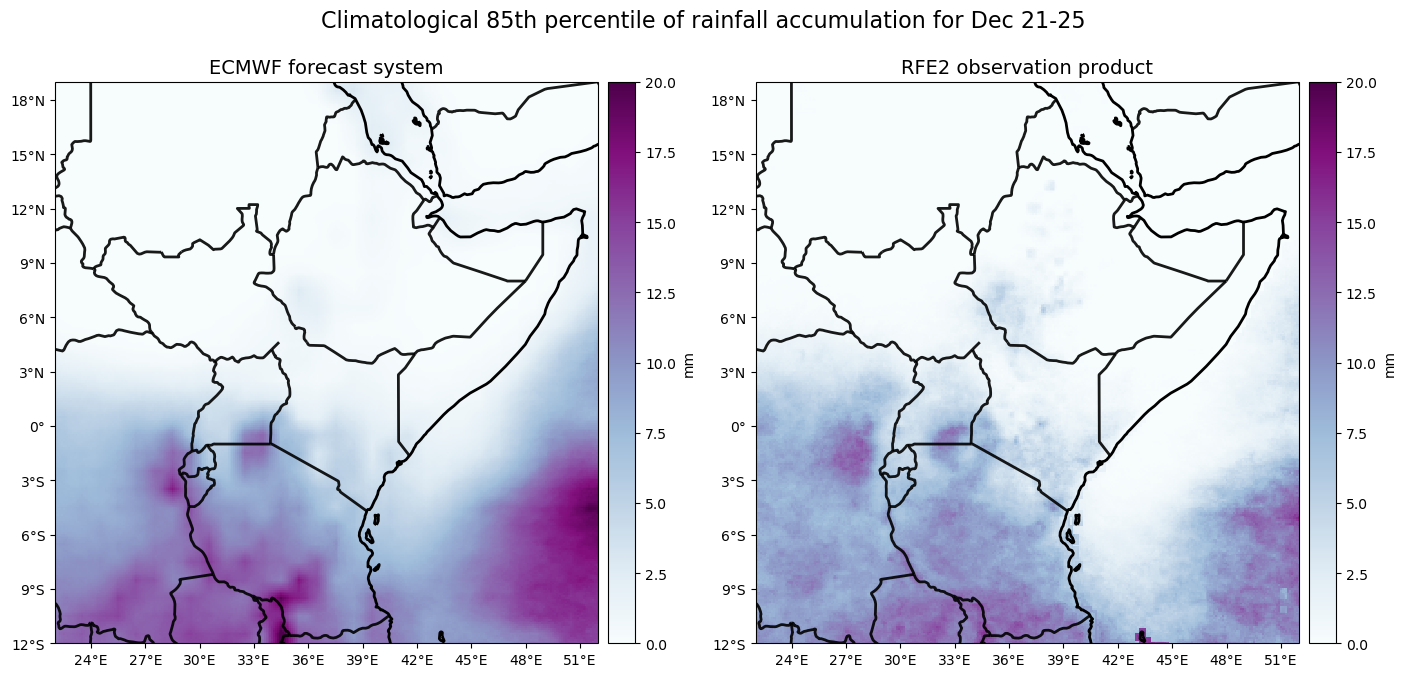

In [6]:
ipct = 85                                # percentile level (integer between 1 and 99)
ipt = 28                                 # number of pentads after forecast initialization dates

month_names = {1:'jan', 2:'feb', 3:'mar', 4:'apr', 5:'may', 6:'jun', 7:'jul', 8:'aug', 9:'sep', 10:'oct', 11:'nov', 12:'dec'}

month_init_int = [i for i in range(1,13) if month_names[i]==month_init][0]
jpt = (6*(month_init_int-1)+ipt) % 72    # corresponding number of pentads after January 1

month_valid_int = jpt//6 + 1
month_valid_str = month_names[month_valid_int].capitalize()

dd_pentad_start = 5*(jpt-6*(month_valid_int-1)) + 1
dd_pentad_end = 5*(jpt-6*(month_valid_int-1)) + 5

plot_fields (fields_list = [pctl_fcst[ipt,ipct-1,:,:],pctl_target[jpt,ipct-1,:,:]],
          lon = lon_target,
          lat = lat_target,
          lon_bounds = [22, 52],
          lat_bounds = [-12, 19],
          main_title = f'Climatological {ipct}th percentile of rainfall accumulation for {month_valid_str} {dd_pentad_start}-{dd_pentad_end}',
          subtitle_list = [f'{system.upper()} forecast system',f'{target.upper()} observation product'],
          vmin = 0,
          vmax = 20,
          unit = 'mm')

As a further sanity check, we pick a particular location and look at the cumulative distribution functions (CDFs) of the forecast and target climatology, represented via the 1st through 99th percentile. Note that the CDFs are specific to time of the year, i.e. they will change based on the pentad selected above. 

Text(0.5, 1.0, 'Climatological CDFs at Upper Tana basin (Dec 21-25)')

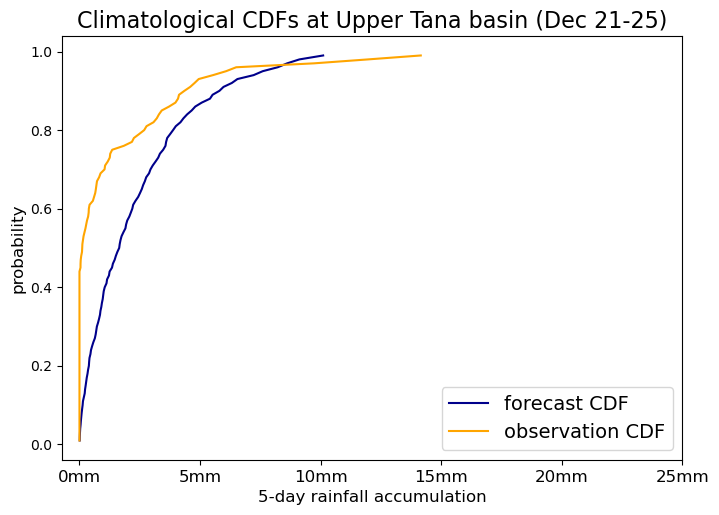

In [7]:
lon_exmpl = 37.25                 # longitude of example location
lat_exmpl = -0.75                 # latitude of example location
name_exmpl = 'Upper Tana basin'   # name of the selected location

ix, iy = get_nearest_grid_index(lon_exmpl, lat_exmpl, lon_target, lat_target)

pct_level = np.arange(1,100)

plt.figure(figsize=(8,5.5))
ax = plt.subplot(1, 1, 1)
ax.plot(pctl_fcst[ipt,:,iy,ix], pct_level/100, color='darkblue', label='forecast CDF')
ax.plot(pctl_target[jpt,:,iy,ix], pct_level/100, color='orange', label='observation CDF')
ax.set_xticks([*range(0,26,5)])
ax.set_xticklabels([f'{i}mm' for i in range(0,26,5)], fontsize=12)
ax.set_xlabel('5-day rainfall accumulation', fontsize=12)
ax.set_ylabel('probability', fontsize=12)
ax.legend(loc='lower right', fontsize=14)
ax.set_title(f'Climatological CDFs at {name_exmpl} ({month_valid_str} {dd_pentad_start}-{dd_pentad_end})', fontsize=16)

If everything looks reasonable, we can use these percentiles to bias-correct the forecast from the selected year.

In [8]:
filename_precip_dwnsc = f'{output_dir}forecast_{system}_dwnsc_{target}_{month_init}_{year_fcst}.nc'

if not path.exists(filename_precip_dwnsc):
    downscale_forecasts(system, year_fcst, month_init, pctl_fcst, pctl_target, lon_target, lat_target, fcst_dir, filename_precip_dwnsc)

data_load = xr.open_dataset(filename_precip_dwnsc, engine='netcdf4')
precip_dwnsc = data_load.precip.values
data_load.close()

Loading and interpolating forecast data ...
Processing pentad 1/42 ...
Processing pentad 11/42 ...
Processing pentad 21/42 ...
Processing pentad 31/42 ...
Processing pentad 41/42 ...
Output saved as '/home/confer/michael/Data/Forecasts_downscaled/forecast_ecmwf_dwnsc_rfe2_aug_2024.nc'.


For comparison, we load and interpolate the raw ensemble forecasts...

In [9]:
precip_fcst = load_and_interpolate_forecast(system, year_fcst, month_init, lon_target, lat_target, fcst_dir)

Loading and interpolating forecast data ...


... which we can then plot along with the bias-corrected forecast for a given lead time and ensemble member.

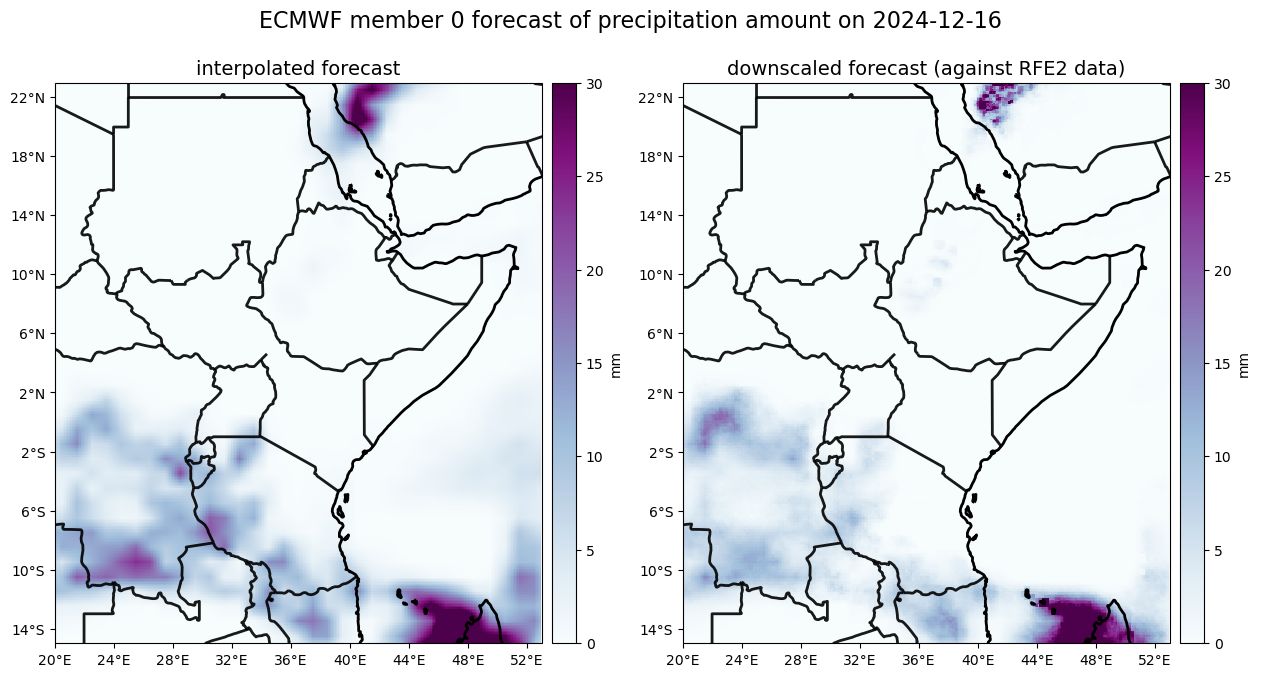

In [10]:
ilt = 138      # forecast lead time in days
imb = 0        # ensemble member

month_init_int = [i for i in range(1,13) if month_names[i]==month_init][0]

date_valid =  datetime.date(year_fcst, month_init_int, 1) + datetime.timedelta(days=ilt-1)

plot_fields (fields_list = [precip_fcst[imb,ilt-1,:,:],precip_dwnsc[imb,ilt-1,:,:]],
          lon = lon_target,
          lat = lat_target,
          lon_bounds = lon_bnds,
          lat_bounds = lat_bnds,
          main_title = f'{system.upper()} member {imb} forecast of precipitation amount on {date_valid}',
          subtitle_list = ['interpolated forecast',f'downscaled forecast (against {target.upper()} data)'],
          vmin = 0,
          vmax = 30,
          unit = 'mm')